# Face Mask Detector (TRANSFER LEARNING)


# Import Packages


In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import cv2
import tensorflow as tf
from tensorflow import keras

# Reporocessing 
the dataset is given in one folder and the main parametre to split into two classes is the name
the images containing faces with face mask in named face_with_mask_X
the images containing faces with no mask in named face_without_mask_X



Creating two folders to split the images with masks and no masks

In [42]:
#Creating the directories
os.mkdir('Temp')
os.mkdir('Temp/Mask')
os.mkdir('Temp/No Mask')

#Spliting the images
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if 'face_with_mask' in filename:
            print('image : {} '.format(filename)+' Added to the directory Mask')
            shutil.copy('/kaggle/input/mask-detection/face_mask_data/'+filename, '/kaggle/working/Temp/Mask')
        elif 'face_without_mask' in filename:
            print('image : {} '.format(filename)+' Added to the directory No Mask')
            shutil.copy('/kaggle/input/mask-detection/face_mask_data/'+filename, '/kaggle/working/Temp/No Mask')

FileExistsError: [Errno 17] File exists: 'Temp'

In [43]:
data_path='/kaggle/working/Temp/'
categories=os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict=dict(zip(categories,labels)) #empty dictionary

print(labels)
print(categories)
print(label_dict)
    

[0, 1]
['Mask', 'No Mask']
{'Mask': 0, 'No Mask': 1}


In [44]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           
            resized=cv2.resize(img,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [7]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,3))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


# **USING MOBILENET V2 FOR TRANSFER LEARNING**

In [10]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
include_top = False,
    pooling = "avg",
    weights = "imagenet",input_shape = (100,100,3)
)
mnet.summary()

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
________________

In [11]:
def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,activation = "sigmoid")
    ])
    
    model.layers[0].trainable = False
    model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["accuracy"])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.fit(data,target,epochs = 30)

Train on 995 samples
Epoch 1/30
995/995 [==============================] - 10s 10ms/sample - loss: 0.8369 - accuracy: 0.5467
Epoch 2/30
995/995 [==============================] - 7s 7ms/sample - loss: 0.5834 - accuracy: 0.7065
Epoch 3/30
995/995 [==============================] - 7s 7ms/sample - loss: 0.4466 - accuracy: 0.7970
Epoch 4/30
995/995 [==============================] - 7s 7ms/sample - loss: 0.4049 - accuracy: 0.8181
Epoch 5/30
995/995 [==============================] - 7s 7ms/sample - loss: 0.3856 - accuracy: 0.8422
Epoch 6/30
995/995 [==============================] - 7s 7ms/sample - loss: 0.3776 - accuracy: 0.8382
Epoch 7/30
995/995 [==============================] - 7s 7ms/sample - loss: 0.3239 - accuracy: 0.8583
Epoch 8/30
995/995 [==============================] - 7s 7ms/sample - loss: 0.3251 - accuracy: 0.8603
Epoch 9/30
995/995 [==============================] - 8s 8ms/sample - loss: 0.3199 - accuracy: 0.8633
Epoch 10/30
995/995 [==============================] - 8s 8

In [62]:
def predictions(data):
    plt.figure(figsize = (20,20))
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(data[i])
        img = np.expand_dims(data[i],axis = 0)
        if model.predict(img)<0.5:
            plt.xlabel("mask")
        elif model.predict(img)>0.5:
            plt.xlabel("no mask")

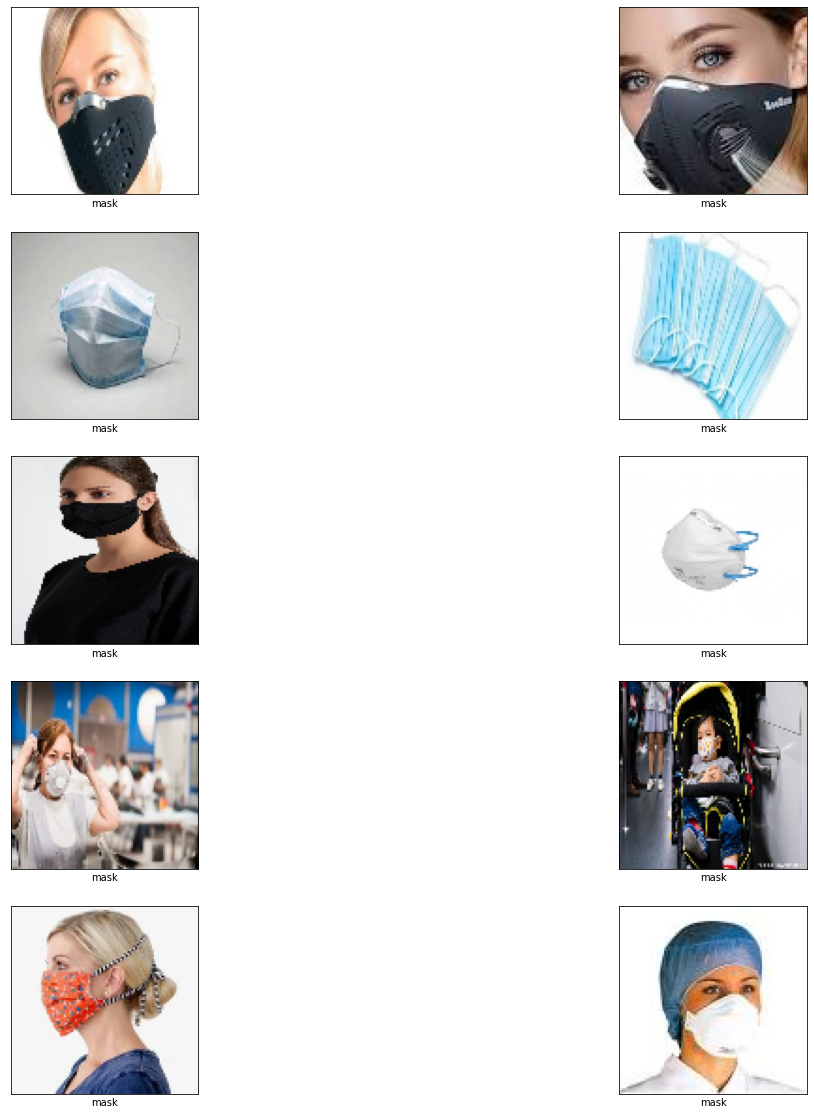

In [63]:
predictions(data)